In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [6]:
!pip install -U scikit-learn

In [7]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2025-11-18 13:32:41--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2025-11-18 13:32:41 ERROR 500: Internal Server Error.



In [8]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [9]:
df['LogPassengers'] = np.log(df['Passengers'])

In [10]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [11]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [15]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

# we reshape X with 3 dimensions because input layer of CNN takes 2-d data for each sample
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [16]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [17]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i) # 16 feature maps and filter of size 3
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x) # 32 feature maps and filter of size 3. Note that #feature maps is increasing
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [19]:
model.summary()
'''
by default convolution is in "valid" mode, so:
In first convolution when size 3 filter acts on 10 size input, output is of size 10 - 3 + 1 = 8
In second convolution when size 3 filter acts on 4 size input, output is of size 4 - 3 + 1 = 2
'''
'''
Number of parameters at first convolution:
  Number of feature maps = 16 and filter size = 3
  Number of bias parameters = Number of feature maps = 16
  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series
                                = 16 * 3 * 1 = 48
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 16 + 48 = 64
'''
'''
Number of parameters at second convolution:
  Number of feature maps = 32 and filter size = 3
  Number of bias parameters = Number of feature maps = 32
  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series
                                = 32 * 3 * 16 = 1536
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 32 + 1536 = 1568
'''

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

'\nNumber of parameters at second convolution: \n  Number of feature maps = 32 and filter size = 3\n  Number of bias parameters = Number of feature maps = 32\n  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series\n                                = 32 * 3 * 16 = 1536\nNumber of total parameters = Number of bias parameters + Number of non-bias parameters = 32 + 1536 = 1568\n'

In [20]:
model.compile(
  loss='mse',
  optimizer='adam',
) # loss is mse because it is regression task

In [21]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0070 - val_loss: 0.0079
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0043 - val_l

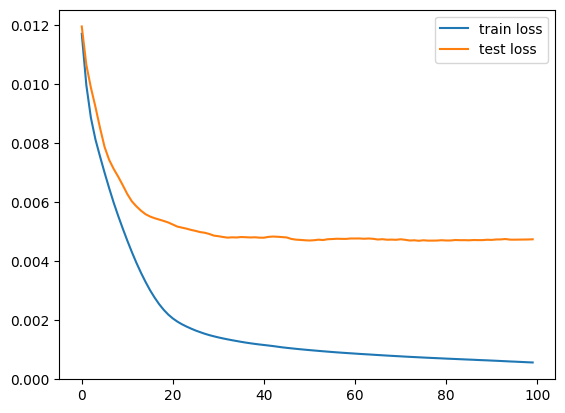

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [23]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [24]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [25]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

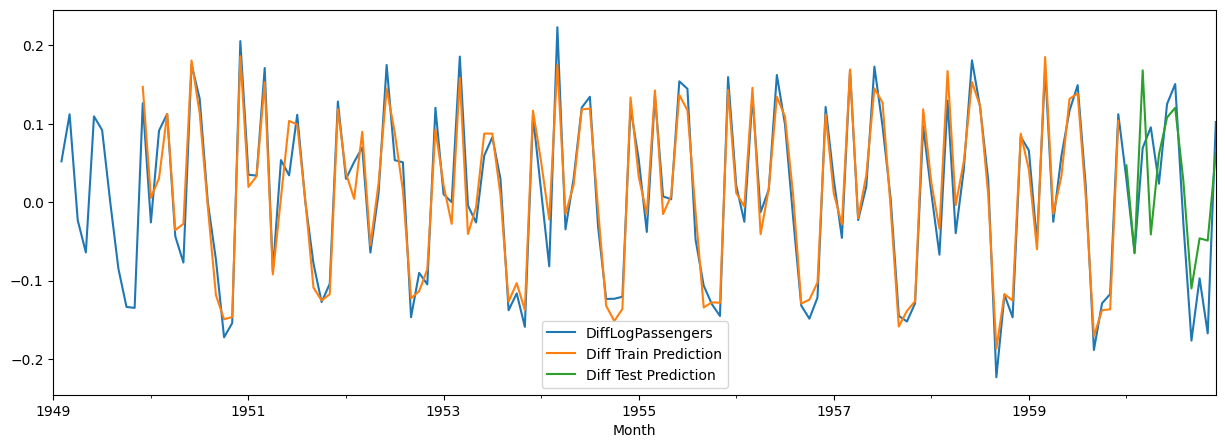

In [26]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(15, 5));

In [27]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [28]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [29]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

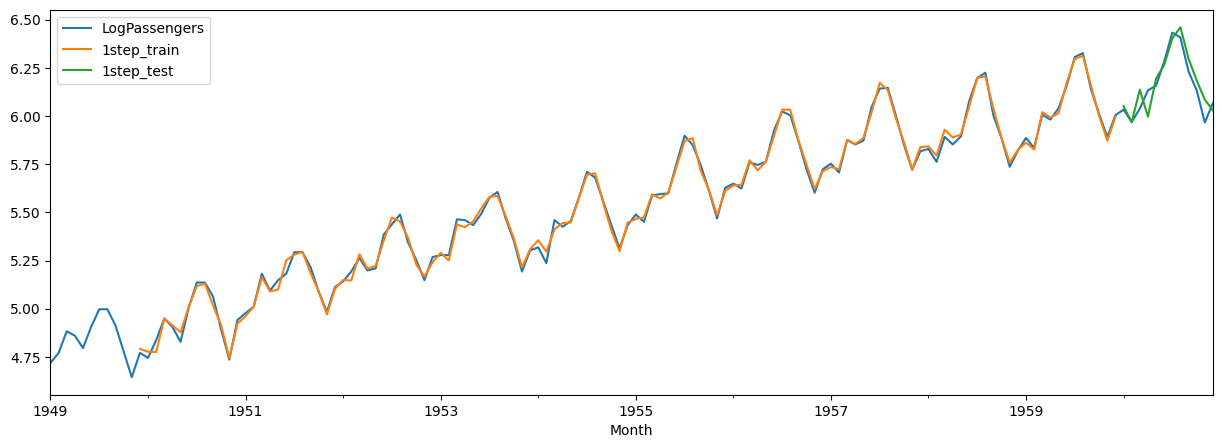

In [30]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [31]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) # these 2 lines discard oldest data and append newest prediction
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [32]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

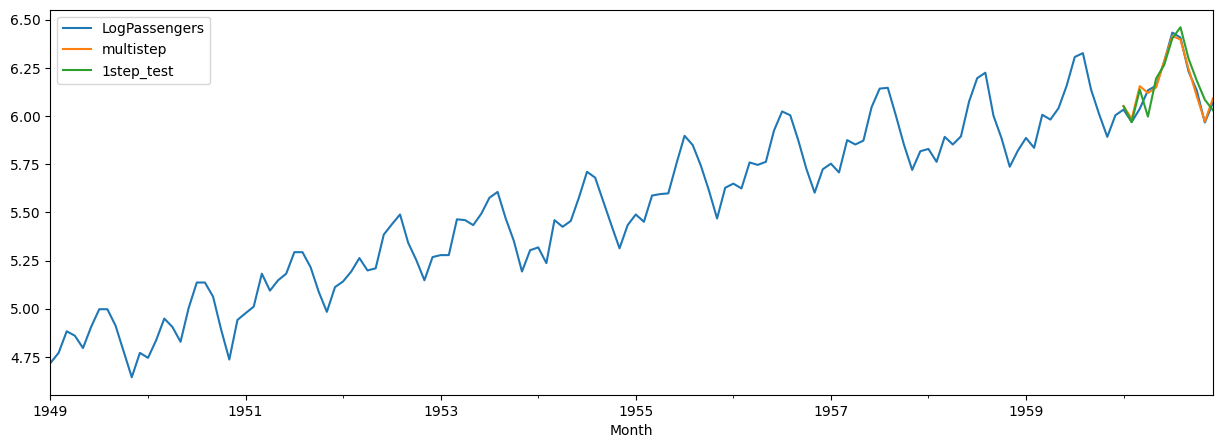

In [33]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [34]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [35]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:] # Xtest_m and Ytest_m have only single row

In [36]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i) # 16 feature maps and filter of size 3
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x) # 32 feature maps and filter of size 3. Note that #feature maps is increasing
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [38]:
model.summary()
'''
by default convolution is in "valid" mode, so:
In first convolution when size 3 filter acts on 10 size input, output is of size 10 - 3 + 1 = 8
In second convolution when size 3 filter acts on 4 size input, output is of size 4 - 3 + 1 = 2
'''
'''
Number of parameters at first convolution:
  Number of feature maps = 16 and filter size = 3
  Number of bias parameters = Number of feature maps = 16
  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series
                                = 16 * 3 * 1 = 48
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 16 + 48 = 64
'''
'''
Number of parameters at second convolution:
  Number of feature maps = 32 and filter size = 3
  Number of bias parameters = Number of feature maps = 32
  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series
                                = 32 * 3 * 16 = 1536
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 32 + 1536 = 1568
'''

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,028 (7.92 KB)

 Trainable params: 2,028 (7.92 KB)

 Non-trainable params: 0 (0.00 B)

'\nNumber of parameters at second convolution: \n  Number of feature maps = 32 and filter size = 3\n  Number of bias parameters = Number of feature maps = 32\n  Number of non-bias parameters = Number of feature maps * filter size * number of dimensions in time series\n                                = 32 * 3 * 16 = 1536\nNumber of total parameters = Number of bias parameters + Number of non-bias parameters = 32 + 1536 = 1568\n'

In [39]:
model.compile(
  loss='mse',
  optimizer='adam',
) # loss is mse because task is regression

In [40]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=200,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0091 - val_lo

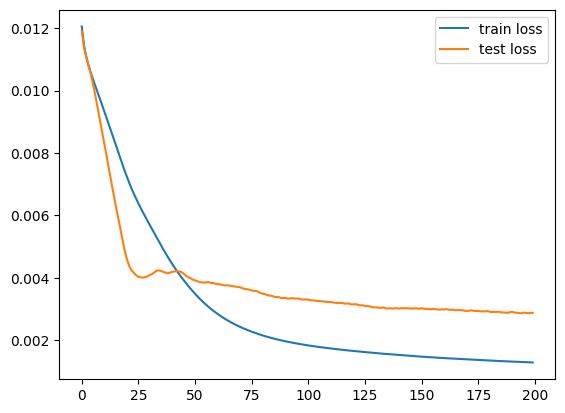

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [42]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [43]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [44]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

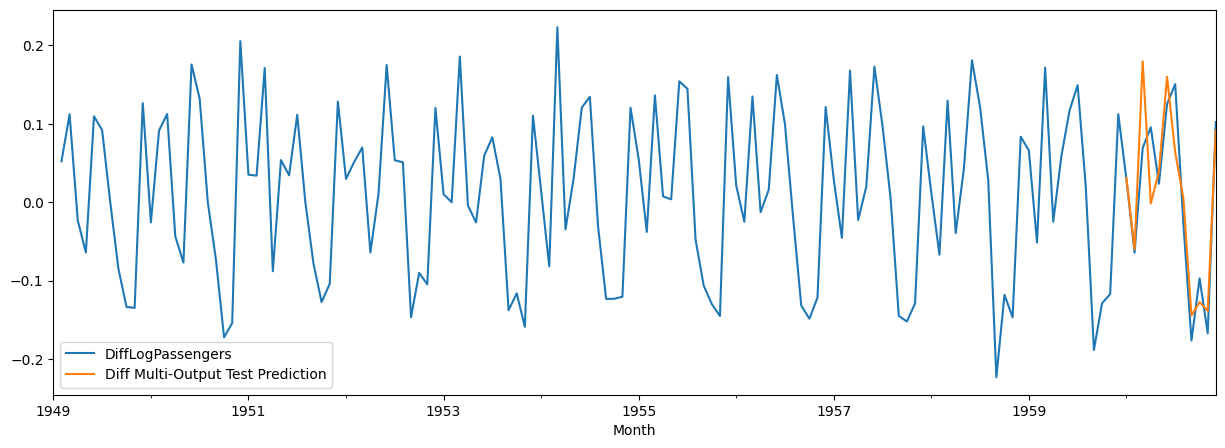

In [45]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15, 5));

In [46]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

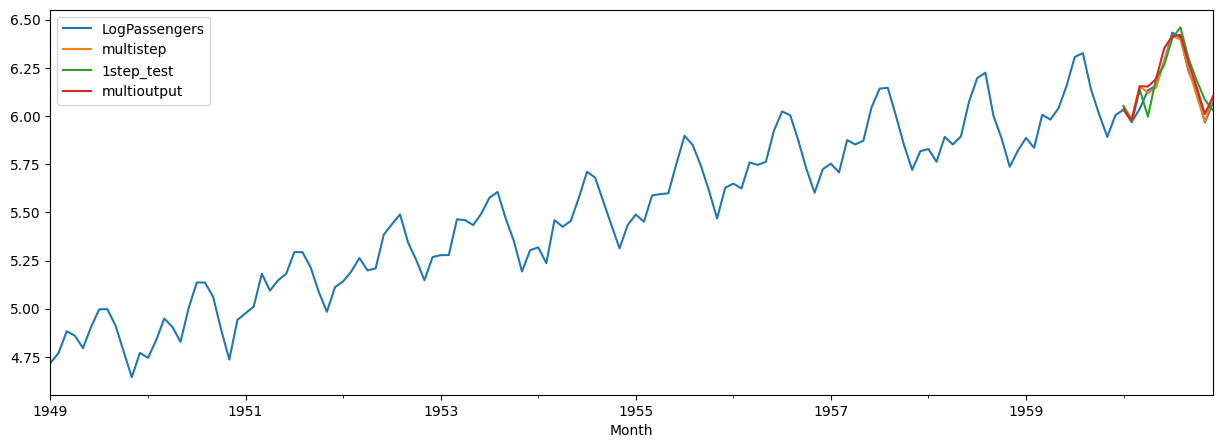

In [47]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [49]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape0 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test'])
print("1step MAPE:", mape0)
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

1step MAPE: 0.009074779087573898
multi-step MAPE: 0.003788638823801168
multi-output MAPE: 0.005685709572005137


In [ ]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?